# **User Game Proficiency Analysis**

**User Game Proficiency Clustering Visualization, Level Difficulty Visualization.**



This project analyzes user game proficiency and establishes user rating criteria. Based on users' gaming behaviors and performance, it quantifies their proficiency levels, categorizing users into different levels of gaming abilities. This information is utilized to formulate dynamic difficulty rules.

本文分析用户游戏水平，制定用户评分规则。根据用户的游戏行为和游戏表现，量化用户水平，划分用户游戏能力等级，用于制定动态难度规则。

In [ ]:
import matplotlib as mpl
!wget -O /usr/share/fonts/truetype/liberation/simhei.ttf "https://www.wfonts.com/download/data/2014/06/01/simhei/chinese.simhei.ttf"
zhfont = mpl.font_manager.FontProperties(fname='/usr/share/fonts/truetype/liberation/simhei.ttf')
# plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

In [ ]:
! pip install scikit-plot

In [ ]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder

# eda
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

# clustering
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler
import scikitplot as skplot
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import metrics
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA


# prediction models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE


import warnings
warnings.filterwarnings("ignore")

# **Visualization of User Game Behavior and Performance**
## **用户游戏水平可视化**

Selecting aggregated data from 50,000 rows of user and event tables, the research focuses on 50,000 new users during the period from August 1, 2022, to August 31, 2022. The study aims to investigate users' gaming behaviors and performance during this timeframe. Eight specific aggregate indicators have been chosen, as shown in the table below.

选取5万条user和event表聚合数据，研究对象为2022.8.1-2022.8.31期间的5万个新用户，研究内容为用户在此期间的游戏行为和表现。具体选取8个聚合指标，如下表所示。

In [ ]:
df = pd.read_csv('/content/zhancheng2.txt',
header = 0, #None表示没有， 0表示第1行
encoding="utf-8",
# index_col="topic" #没有index列
delimiter="	"
)

In [ ]:
df

,国家,平均每次游戏道具消耗,平均每天道具消耗,平均每关游戏时长,通关率,重玩率,平均每天游戏次数,平均每天升关数
0,印度,0.019672,0.142857,88.548701,0.544262,1.859756,7.261905,3.904762
1,印度,0.080000,0.857143,94.095890,0.626667,1.630435,10.714286,6.571429
2,俄罗斯,0.140000,0.280000,99.420000,0.520000,2.000000,2.000000,1.000000
3,伊拉克,0.066667,0.333333,71.437500,0.866667,1.250000,5.000000,4.000000
4,哥伦比亚,0.153846,0.500000,31.928571,0.769231,1.444444,3.250000,2.250000
...,...,...,...,...,...,...,...,...
49995,印度,0.296296,2.666667,84.444444,0.814815,1.285714,9.000000,7.000000
49996,尼日利亚,0.105263,0.500000,65.040000,0.947368,1.117647,4.750000,4.250000
49997,巴基斯坦,0.076923,0.500000,49.333333,0.846154,1.300000,6.500000,5.000000
49998,埃及,0.012097,0.166667,121.983968,0.344758,2.917647,13.777778,4.722222


In [ ]:
La = LabelEncoder()

The research subjects come from 184 countries, and the country names have been processed into numerical types as follows.


研究对象来自184个国家，将国家名称处理为数字类型，如下。

In [ ]:
df['国家_num'] = La.fit_transform(df['国家'])
label_dict = {classes:number for number, classes in enumerate(La.classes_)}
print(label_dict)

{'中国': 0, '中国台湾': 1, '中国澳门': 2, '中国香港': 3, '丹麦': 4, '乌克兰': 5, '乌兹别克斯坦': 6, '乌干达': 7, '乌拉圭': 8, '乍得': 9, '也门': 10, '亚美尼亚': 11, '以色列': 12, '伊拉克': 13, '伊朗': 14, '佛得角': 15, '俄罗斯': 16, '保加利亚': 17, '克罗地亚': 18, '关岛': 19, '冰岛': 20, '刚果(金)': 21, '利比亚': 22, '利比里亚': 23, '加拿大': 24, '加蓬': 25, '匈牙利': 26, '北马里亚纳群岛': 27, '南非': 28, '博茨瓦纳': 29, '卡塔尔': 30, '卢旺达': 31, '卢森堡': 32, '印度': 33, '印度尼西亚': 34, '危地马拉': 35, '厄瓜多尔': 36, '叙利亚': 37, '古巴': 38, '吉尔吉斯斯坦': 39, '吉布提': 40, '哈萨克斯坦': 41, '哥伦比亚': 42, '哥斯达黎加': 43, '喀麦隆': 44, '土库曼斯坦': 45, '土耳其': 46, '圣卢西亚': 47, '圣基茨和尼维斯': 48, '圣多美和普林西比': 49, '圣文森特和格林纳丁斯': 50, '圭亚那': 51, '坦桑尼亚': 52, '埃及': 53, '埃塞俄比亚': 54, '塔吉克斯坦': 55, '塞尔维亚': 56, '塞拉利昂': 57, '塞浦路斯': 58, '墨西哥': 59, '多哥': 60, '多米尼克': 61, '多米尼加共和国': 62, '奥地利': 63, '委内瑞拉': 64, '孟加拉': 65, '安哥拉': 66, '安提瓜和巴布达': 67, '安道尔': 68, '密克罗尼西亚联邦': 69, '尼加拉瓜': 70, '尼日利亚': 71, '尼日尔': 72, '尼泊尔': 73, '巴勒斯坦': 74, '巴哈马': 75, '巴基斯坦': 76, '巴巴多斯': 77, '巴布亚新几内亚': 78, '巴拉圭': 79, '巴拿马': 80, '巴林': 81, '巴西': 82, '布基纳法索': 83, '希腊': 84, '库拉索岛': 

In [ ]:
df = df.drop('国家',1)

In [ ]:
df.describe()

,平均每次游戏道具消耗,平均每天道具消耗,平均每关游戏时长,通关率,重玩率,平均每天游戏次数,平均每天升关数,国家_num
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,0.154724,1.208475,86.790566,0.708767,1.582437,8.464496,5.576358,59.858300
std,0.145367,1.658434,26.767730,0.162508,0.428503,7.268638,4.745791,43.803046
min,0.000915,0.005405,19.900000,0.166667,0.206478,0.208333,0.089577,0.000000
25%,0.079524,0.428571,70.154841,0.584906,1.285714,4.200000,2.714286,33.000000
50%,0.133333,0.800000,88.838835,0.714286,1.482759,6.800000,4.400000,33.000000
75%,0.200000,1.500000,103.435907,0.843750,1.779906,10.222222,7.000000,82.000000
max,10.105882,104.750000,1231.285714,1.200000,12.000000,188.000000,137.000000,183.000000


In [ ]:
# Winsorizing the ratioa variables at 1% and 99% values
from scipy.stats.mstats import winsorize
df['平均每次游戏道具消耗'] = winsorize(df['平均每次游戏道具消耗'], limits = [0.01,0.01])
df['平均每天道具消耗'] = winsorize(df['平均每天道具消耗'], limits = [0.01,0.01])
df['平均每关游戏时长'] = winsorize(df['平均每关游戏时长'], limits= [0.01,0.01])
df['通关率'] = winsorize(df['通关率'], limits = [0.01,0.01])
df['重玩率'] = winsorize(df['重玩率'], limits = [0.01,0.01])
df['平均每天游戏次数'] = winsorize(df['平均每天游戏次数'], limits = [0.01,0.01])
df['平均每天升关数'] = winsorize(df['平均每天升关数'], limits = [0.01,0.01])

Text(0.5, 1.0, '消除异常值后数据分布箱线图')

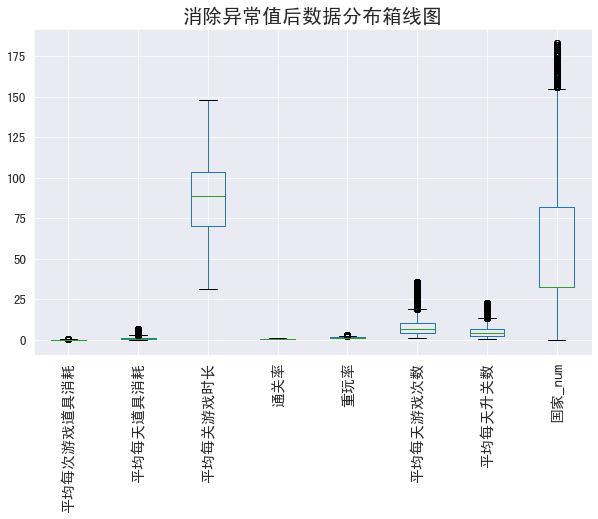

In [ ]:
# Check outliers
# Plot the boxplot od ratio features which are within the same scale
plt.figure(figsize=(10,6))
df.boxplot(column= [i for i in df.columns.tolist()]);
# plt.ylim([-50, 100])
plt.xticks(fontproperties=zhfont,rotation=90,size=15)
plt.yticks(fontproperties=zhfont,size=13)

plt.title("消除异常值后数据分布箱线图", fontproperties=zhfont, fontsize=20)

In [ ]:
# scaling
sc = StandardScaler()
df_scaled = sc.fit_transform(df)
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

In [ ]:
df_scaled

,平均每次游戏道具消耗,平均每天道具消耗,平均每关游戏时长,通关率,重玩率,平均每天游戏次数,平均每天升关数,国家_num
0,-1.249237,-0.868480,0.079604,-1.020717,0.701341,-0.171208,-0.386728,-0.613167
1,-0.679133,-0.260327,0.301012,-0.510476,0.128314,0.394069,0.269153,-0.613167
2,-0.112128,-0.751715,0.513516,-1.170947,1.051782,-1.032769,-1.101170,-1.001271
3,-0.805134,-0.706306,-0.603364,0.975582,-0.822314,-0.541563,-0.363303,-1.069761
4,0.018719,-0.564404,-2.180304,0.372268,-0.336437,-0.828100,-0.793725,-0.407699
...,...,...,...,...,...,...,...,...
49995,1.364885,1.280327,-0.084211,0.654520,-0.733072,0.113380,0.374563,-0.613167
49996,-0.440394,-0.564404,-0.858710,1.475280,-1.153037,-0.582496,-0.301815,0.254362
49997,-0.708210,-0.564404,-1.485618,0.848568,-0.697375,-0.295959,-0.117348,0.368510
49998,-1.320825,-0.848208,1.414123,-2.205360,3.344794,0.895672,-0.185669,-0.156573


In [ ]:
df_scaled.to_csv('/content/zhanchengscaled.csv')

In [ ]:
# k means
# KMeans Clustering
# Find the suitable K for the dataset
KRANGE = range(2, 20)

X = df_scaled
X = pd.DataFrame(X)
j = X.copy()

inertia = []
sil_score = []
for k in KRANGE:
    km = KMeans(k)
    lab = km.fit_predict(j)
    inertia.append(km.inertia_)
    s = metrics.silhouette_score(j, km.labels_, metric='euclidean')
    sil_score.append(s)

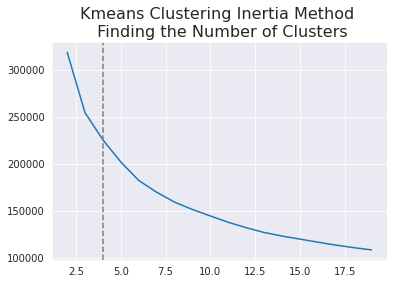

In [ ]:
# inertia score - elbow plot

sns.lineplot(KRANGE, inertia)

plt.axvline(x=4,c='gray', linestyle='--')
plt.title("Kmeans Clustering Inertia Method \n Finding the Number of Clusters", fontsize=16)
plt.show()

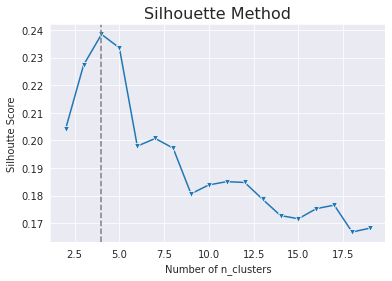

In [ ]:
# Silhouette score
sns.lineplot(x=KRANGE, y=sil_score, marker='v')
plt.title('Silhouette Method', fontsize=16)
plt.xlabel('Number of n_clusters')
plt.ylabel('Silhoutte Score')
plt.axvline(x=4,c='gray', linestyle='--')
plt.show()

In [ ]:
# predict with k=4
k4 = KMeans(4,random_state=820)
k4_label = k4.fit_predict(df_scaled)

In [ ]:
# append labels to the original dataset
df_scaled['k4'] = k4_label
pd.set_option('display.max_colwidth', 50)
df_scaled.head(3)

,平均每次游戏道具消耗,平均每天道具消耗,平均每关游戏时长,通关率,重玩率,平均每天游戏次数,平均每天升关数,国家_num,k4
0,-1.249237,-0.868480,0.079604,-1.020717,0.701341,-0.171208,-0.386728,-0.613167,1
1,-0.679133,-0.260327,0.301012,-0.510476,0.128314,0.394069,0.269153,-0.613167,1
2,-0.112128,-0.751715,0.513516,-1.170947,1.051782,-1.032769,-1.101170,-1.001271,1


In [ ]:
# count of each cluster
df_scaled.k4.value_counts()

3    22484
1    18757
2     4489
0     4270
Name: k4, dtype: int64

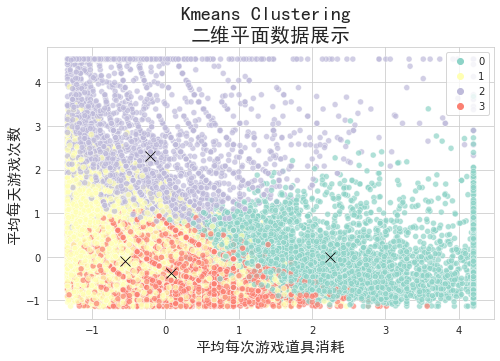

In [ ]:
# visualize with cluster centers
fig = plt.figure(figsize=(8,5))
X = df_scaled
X = pd.DataFrame(X)

sns.scatterplot(X.values[:,0], X.values[:,5], hue =X.k4, palette = 'Set3', s=35, alpha = 0.7)
sns.scatterplot(k4.cluster_centers_[:,0] ,k4.cluster_centers_[:,5], color='black', marker="x", s=100)

plt.xlabel('平均每次游戏道具消耗', fontproperties=zhfont, size=15)
plt.ylabel('平均每天游戏次数', fontproperties=zhfont,size=15)
plt.title("Kmeans Clustering \n二维平面数据展示", fontproperties=zhfont, fontsize=20)
plt.show()

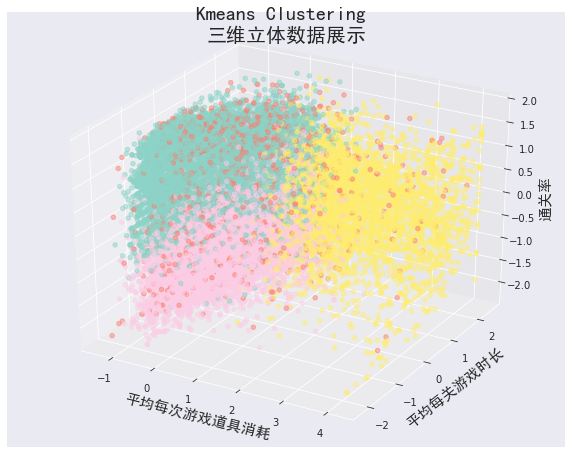

In [ ]:
# Three-dimensional Cluster Visualization (PCA)
ax = plt.figure(figsize=(10,8)).gca(projection='3d')
ax.scatter(
    xs=X.values[:,0],
    ys=X.values[:,2],
    zs=X.values[:,3],
    c=df_scaled["k4"],
    cmap='Set3_r',
alpha = 0.5)
ax.set_xlabel('平均每次游戏道具消耗',fontproperties=zhfont, size = 15)
ax.set_ylabel('平均每关游戏时长',fontproperties=zhfont, size = 15)
ax.set_zlabel('通关率',fontproperties=zhfont,rotation = 90, size = 15)

# ax.view_init(60,35)
plt.title("Kmeans Clustering \n三维立体数据展示", fontproperties=zhfont,size = 20)
plt.show()

In [ ]:
profile = df_scaled.groupby('k4').mean()
# profile['avg_total_spend'] = profile.loc[:, 'meat': 'gold'].sum(axis = 1)
# profile['meat_perc'] = profile['meat']/profile['avg_total_spend']
# profile['fruits_perc'] = profile['fruits']/profile['avg_total_spend']
# profile['fish_perc'] = profile['fish']/profile['avg_total_spend']
# profile['sweets_perc'] = profile['sweets']/profile['avg_total_spend']
# profile['wines_perc'] = profile['wines']/profile['avg_total_spend']
# profile['gold_perc'] = profile['gold']/profile['avg_total_spend']
profile.T

k4,0,1,2,3
平均每次游戏道具消耗,2.250112,-0.548337,-0.214745,0.072993
平均每天道具消耗,1.648449,-0.453408,1.307952,-0.195948
平均每关游戏时长,0.756656,0.406849,0.301775,-0.543357
通关率,0.098892,-0.926773,0.077206,0.738953
重玩率,-0.293642,0.861868,-0.210810,-0.621148
平均每天游戏次数,-0.009528,-0.090256,2.303621,-0.382821
平均每天升关数,0.074124,-0.340562,2.407611,-0.210654
国家_num,0.314120,-0.241004,-0.061948,0.153767


对比五万条数据的平均值和分组后每组数据的平均值，如表1和表2，若表2中某组的数据显著不同于表1，表示，这个显著不一样的数值就是每组的特性。总览结果如下表。
游戏水平能力排名为：组4 ＞ 组3 ＞ 组1 ＞ 组2
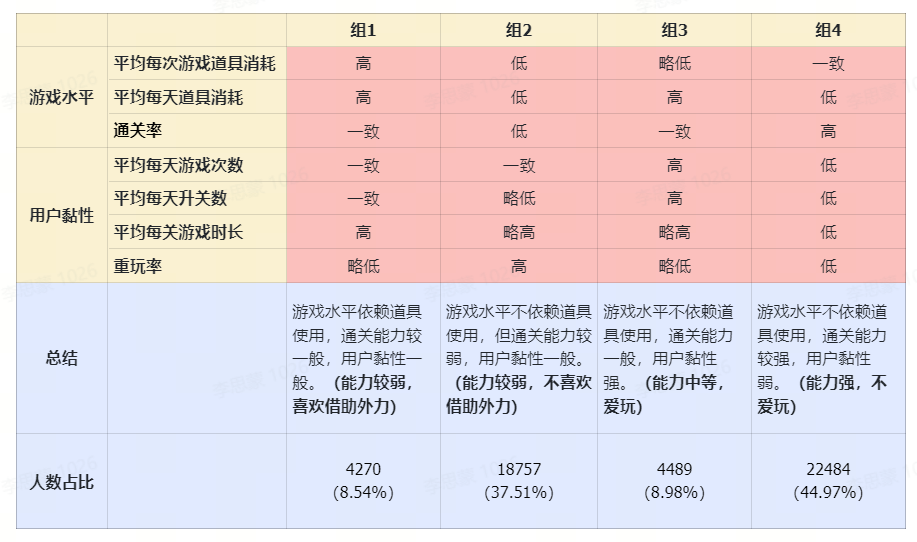

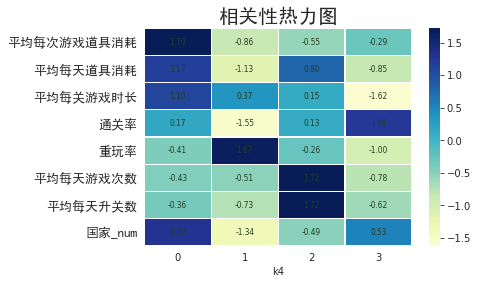

In [ ]:
# plot heatmap
scp = StandardScaler()
profile_s = scp.fit_transform(profile)
profile_s = pd.DataFrame(profile_s, index=profile.index, columns=profile.columns)

plt.yticks(fontproperties=zhfont,size=13)
sns.heatmap(profile_s.T, linewidths=.2, cmap="YlGnBu",
                 annot=True,#show the annotations
                 fmt=".2f",#keep 2 digits
                 annot_kws={'size':7.5,'weight':'normal', 'color':'#253D24'},center=0)

plt.title("相关性热力图", fontproperties=zhfont,size = 20)
plt.show()

In [ ]:
profile_p

k4,0,1,2,3
平均每次游戏道具消耗,0.389970,0.093841,0.129141,0.159589
平均每天道具消耗,3.099033,0.630366,2.699113,0.932757
平均每关游戏时长,105.511675,96.747539,94.115001,72.940907
通关率,0.725080,0.559434,0.721578,0.828451
重玩率,1.461571,1.923998,1.494720,1.330505
平均每天游戏次数,8.249349,7.756314,22.376700,5.969501
平均每天升关数,5.778481,4.092460,15.265922,4.620638
国家_num,73.617564,49.301701,57.144798,66.593711



To categorize users into four groups based on the given rules, follow the criteria outlined in the correlation heatmap, identifying prominent features for each group and setting thresholds:

**Group 1:**

- Average in-game item consumption per session > 0.35
- Completion rate > 0.6
- Average daily game sessions < 15

**Group 2:**

- Average in-game item consumption per session < 0.15
- Replay rate > 1.5
- Completion rate < 0.7
- Average daily game sessions < 15


**Group 3:**

- Average in-game item consumption per session < 0.20
- Completion rate > 0.6
- Average daily game sessions > 15
- Average daily level advancements > 10


**Group 4:**

- Average in-game item consumption per session < 0.25
- Completion rate > 0.65
- Average daily game sessions < 10
- Average duration per level < 90 minutes

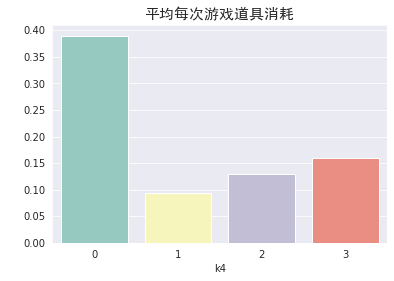

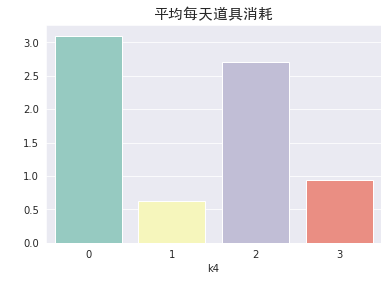

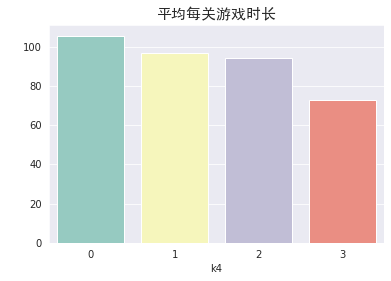

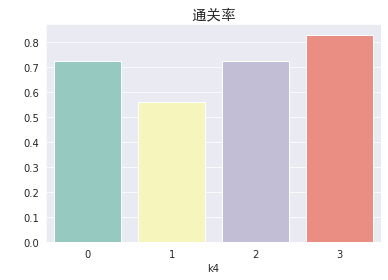

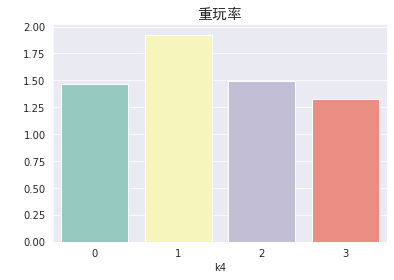

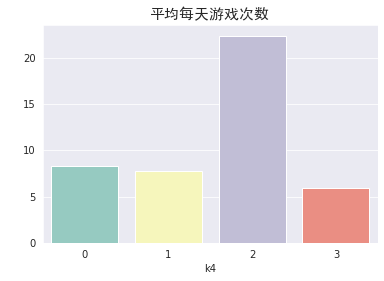

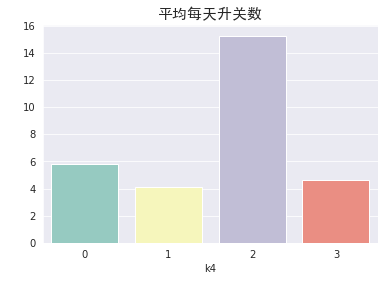

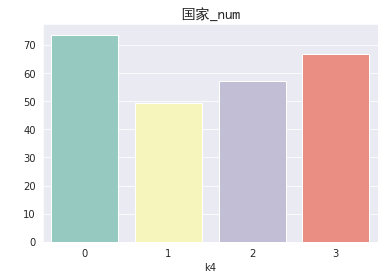

In [ ]:
profile_p = df.copy()
profile_p['k4'] = df_scaled['k4']
profile_p = profile_p.groupby('k4').mean()
# profile_p = profile_p.T


for i in profile.columns.tolist():
  # print(profile_p[str(i)])
  sns.barplot(x = profile.index, y =profile_p[str(i)], data = profile_p, palette = 'Set3')
  plt.title(str(i), fontproperties=zhfont,size = 15)
  plt.ylabel(" ",fontproperties=zhfont,size=15)
  plt.show()

Text(0.5, 1.0, '关卡平均最大通关人数')

<Figure size 600x400 with 0 Axes>

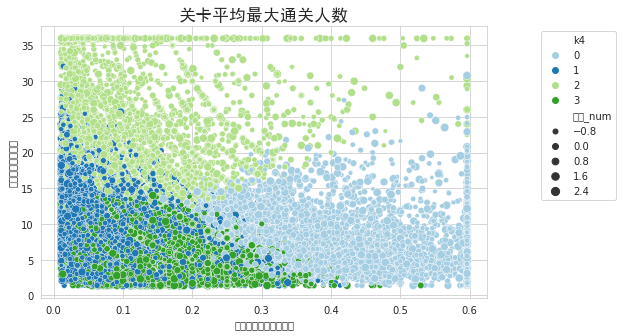

In [ ]:
plt.figure(dpi=100)
plt.figure(figsize=(8,5))

sns.set_style("whitegrid")
sns.scatterplot(data=df_scaled, x = df['平均每次游戏道具消耗'], y=df['平均每天游戏次数'], alpha=1, hue='k4', size='国家_num', palette='Paired')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))

# plt.ylim(0,20000)
plt.title('关卡平均最大通关人数', fontproperties=zhfont, size=17)

In [ ]:
df = pd.read_csv('/content/zhancheng2.txt',
header = 0, #None表示没有， 0表示第1行
encoding="utf-8",
# index_col="topic" #没有index列
delimiter="	"
)
profile_g = df.copy()
profile_g['k4'] = df_scaled['k4']
profile_g = profile_g.groupby(['国家','k4']).count()
profile_g.T

国家          中国            中国台湾             中国澳门 中国香港  ... 马达加斯加 马里       黎巴嫩  \
k4           0  1   2   3    0   1   2   3    0    0  ...     3  1  2  3   0   
平均每次游戏道具消耗  30  3  22  49   10  20  15  36    1    1  ...     2  7  3  2   6   
平均每天道具消耗    30  3  22  49   10  20  15  36    1    1  ...     2  7  3  2   6   
平均每关游戏时长    30  3  22  49   10  20  15  36    1    1  ...     2  7  3  2   6   
通关率         30  3  22  49   10  20  15  36    1    1  ...     2  7  3  2   6   
重玩率         30  3  22  49   10  20  15  36    1    1  ...     2  7  3  2   6   
平均每天游戏次数    30  3  22  49   10  20  15  36    1    1  ...     2  7  3  2   6   
平均每天升关数     30  3  22  49   10  20  15  36    1    1  ...     2  7  3  2   6   

国家                    黑山     
k4           1  2   3  1  3  
平均每次游戏道具消耗  10  3  20  1  2  
平均每天道具消耗    10  3  20  1  2  
平均每关游戏时长    10  3  20  1  2  
通关率         10  3  20  1  2  
重玩率         10  3  20  1  2  
平均每天游戏次数    10  3  20  1  2  
平均每天升关数     10  3  20  1  2  

[7 rows x 577 columns]

# **Visualization of Levels Difficulty**
 ##     **关卡难度可视化**

In [ ]:
np.average(df.pass_rate)

0.9941880570409982

In [ ]:
np.average(df.avg_pass_time)

170.46880570409982

In [ ]:
np.average(df.avg_item_use)

1.0374331550802138

In [ ]:
np.average(df.start_nums)

1.6185383244206775

In [ ]:
np.average(df.avg_max_mode_level)

904.5472370766488

Text(0.5, 1.0, '关卡平均通关时间')

<Figure size 2000x1600 with 0 Axes>

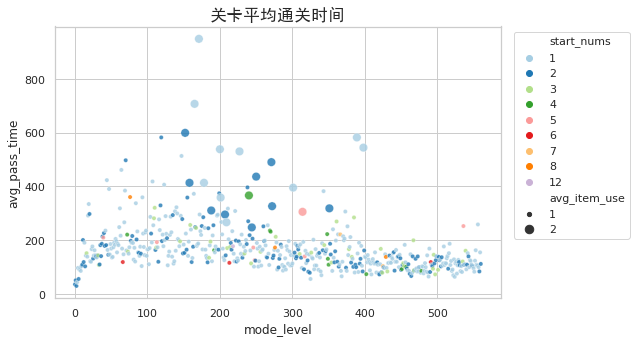

In [ ]:
plt.figure(dpi=100)
plt.figure(figsize=(8,5))

sns.set_style("whitegrid")
sns.scatterplot(data=df, x = df.mode_level, y=df.avg_pass_time, alpha=0.8, hue='start_nums', size='avg_item_use', palette='Paired')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))

plt.title('关卡平均通关时间', fontproperties=zhfont, size=17)

Text(0.5, 1.0, '关卡平均通关率')

<Figure size 2000x1600 with 0 Axes>

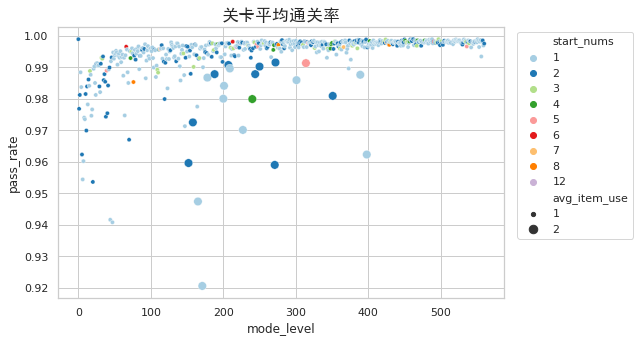

In [ ]:
plt.figure(dpi=100)
plt.figure(figsize=(8,5))

sns.set_style("whitegrid")
sns.scatterplot(data=df, x = df.mode_level, y=df.pass_rate, alpha=1, hue='start_nums', size='avg_item_use', palette='Paired')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))

plt.title('关卡平均通关率', fontproperties=zhfont, size=17)

Text(0.5, 1.0, '关卡平均最大通关人数')

<Figure size 2000x1600 with 0 Axes>

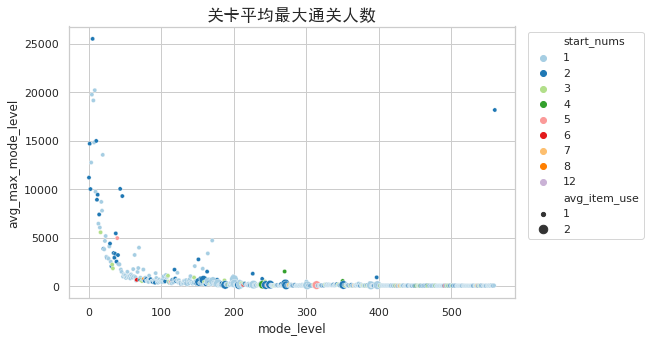

In [ ]:
plt.figure(dpi=100)
plt.figure(figsize=(8,5))

sns.set_style("whitegrid")
sns.scatterplot(data=df, x = df.mode_level, y=df.avg_max_mode_level, alpha=1, hue='start_nums', size='avg_item_use', palette='Paired')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))

# plt.ylim(0,20000)
plt.title('关卡平均最大通关人数', fontproperties=zhfont, size=17)

<Figure size 2000x1600 with 0 Axes>

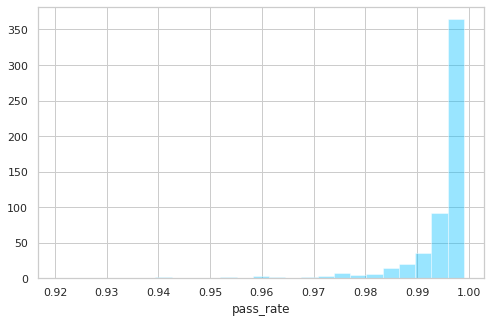

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

plt.figure(dpi=100)
plt.figure(figsize=(8,5))

x = df.mode_level
y = df.pass_rate

sns.distplot(y, bins = 25, color='deepskyblue', kde = False)

# plt.ylim(0.97,1)
# plt.xticks(np.arange(len(x)),x,rotation=90, size = 6)


Text(0.5, 1.0, '关卡平均通关率分布')

<Figure size 2000x1600 with 0 Axes>

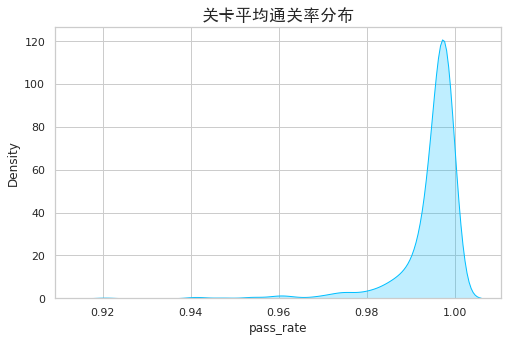

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

plt.figure(dpi=100)
plt.figure(figsize=(8,5))

x = df.mode_level
y = df.pass_rate

sns.kdeplot(y, color='deepskyblue', shade = True)

plt.title('关卡平均通关率分布', fontproperties=zhfont, size=17)

<Figure size 2000x1600 with 0 Axes>

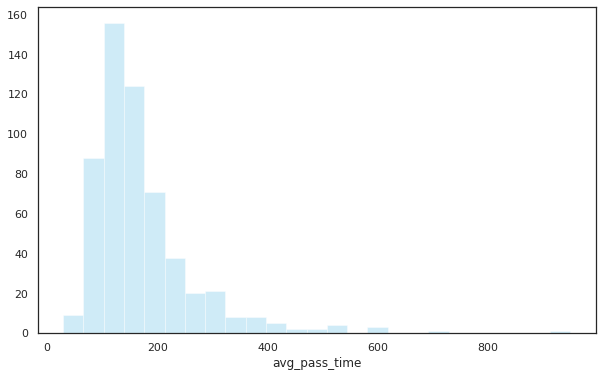

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")

plt.figure(dpi=100)
plt.figure(figsize=(10,6))

x = df.mode_level
y = df.avg_pass_time

sns.distplot(y, bins = 25, color='skyblue', kde = False)

# plt.ylim(0.97,1)
# plt.xticks(np.arange(len(x)),x,rotation=90, size = 6)
plt.show()

Text(0.5, 1.0, '关卡平均通关时间分布')

<Figure size 2000x1600 with 0 Axes>

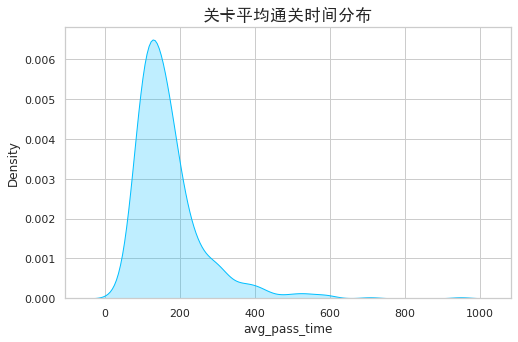

In [ ]:
plt.figure(dpi=100)
plt.figure(figsize=(8,5))

x = df.mode_level
y = df.avg_pass_time

sns.kdeplot(y, color='deepskyblue', shade = True)

plt.title('关卡平均通关时间分布', fontproperties=zhfont, size=17)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<Figure size 2000x1600 with 0 Axes>

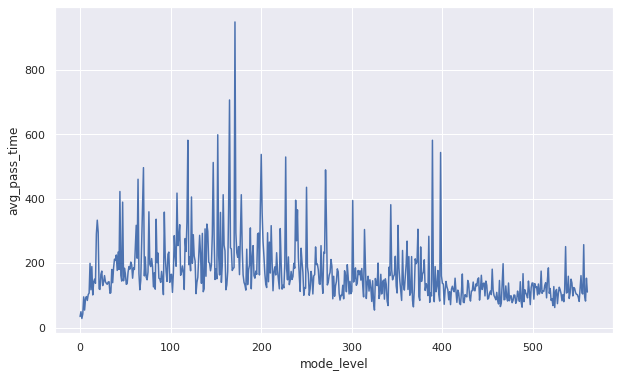

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

plt.figure(dpi=100)
plt.figure(figsize=(10,6))

x = df.mode_level
y = df.avg_pass_time

sns.lineplot(x, y, data=df)
# sns.scatterplot(y, color='skyblue')

# plt.xlim(0,10000)
# plt.xticks(np.arange(len(x)),x,rotation=90, size = 6)
plt.show()

Text(0.5, 1.0, '关卡平均游戏次数分布')

<Figure size 2000x1600 with 0 Axes>

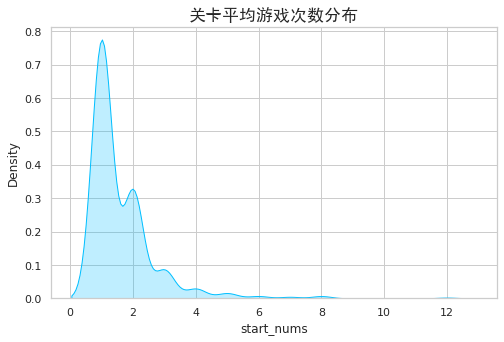

In [ ]:
plt.figure(dpi=100)
plt.figure(figsize=(8,5))

x = df.mode_level
y = df.start_nums

sns.kdeplot(y, color='deepskyblue', shade = True)

plt.title('关卡平均游戏次数分布', fontproperties=zhfont, size=17)

<Figure size 600x400 with 0 Axes>

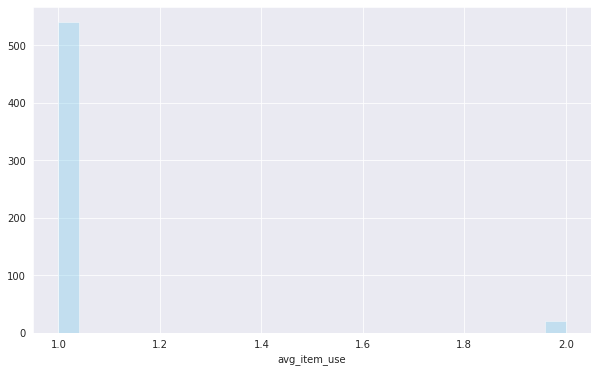

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

plt.figure(dpi=100)
plt.figure(figsize=(10,6))

x = df.mode_level
y = df.pass_rate

sns.distplot(y, bins = 25, color='skyblue', kde = False)

# plt.ylim(0.97,1)
# plt.xticks(np.arange(len(x)),x,rotation=90, size = 6)
plt.show()

<Figure size 600x400 with 0 Axes>

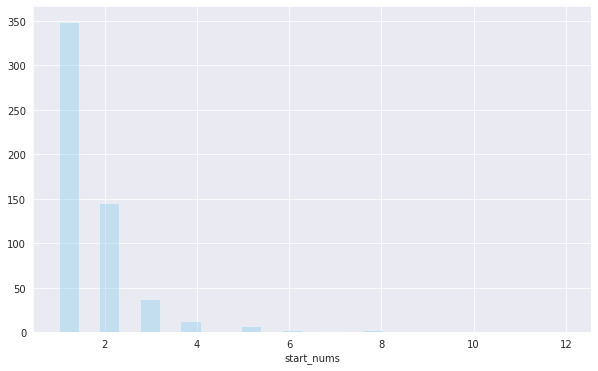

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

plt.figure(dpi=100)
plt.figure(figsize=(10,6))

x = df.mode_level
y = df.start_nums

sns.distplot(y, bins = 25, color='skyblue', kde = False)

# plt.ylim(0.97,1)
# plt.xticks(np.arange(len(x)),x,rotation=90, size = 6)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<Figure size 2000x1600 with 0 Axes>

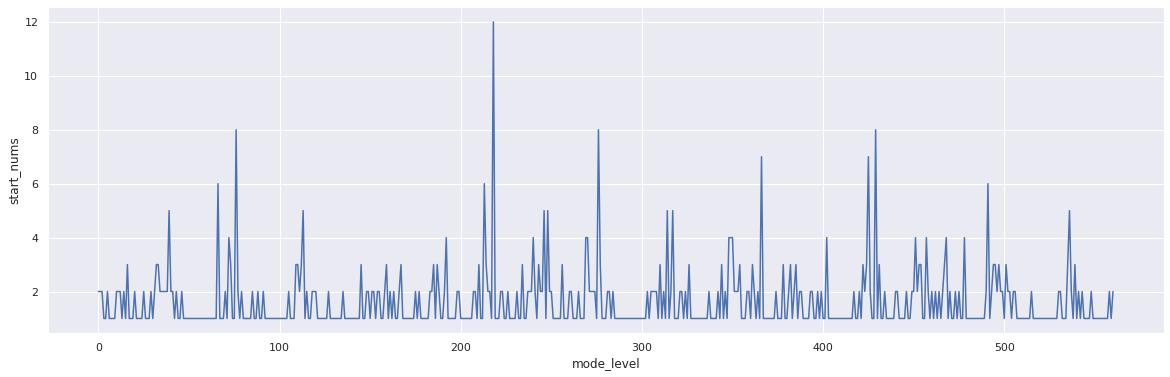

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

plt.figure(dpi=100)
plt.figure(figsize=(20,6))

x = df.mode_level
y = df.start_nums

sns.lineplot(x, y, data=df)
# sns.scatterplot(y, color='skyblue')

# plt.xlim(0,10000)
# plt.xticks(np.arange(len(x)),x,rotation=90, size = 6)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<Figure size 2000x1600 with 0 Axes>

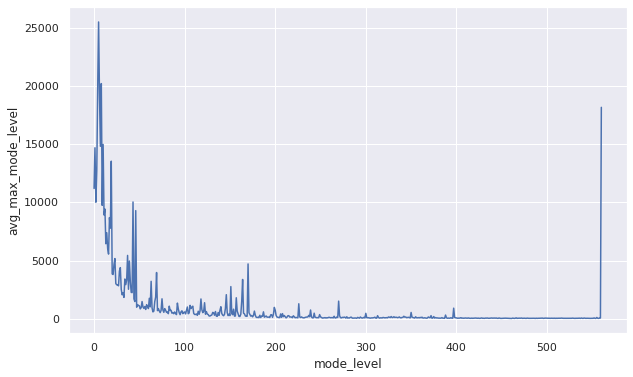

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

plt.figure(dpi=100)
plt.figure(figsize=(10,6))

x = df.mode_level
y = df.avg_max_mode_level

sns.lineplot(x, y, data=df)
# sns.scatterplot(y, color='skyblue')

# plt.xlim(0,10000)
# plt.xticks(np.arange(len(x)),x,rotation=90, size = 6)
plt.show()

Text(0.5, 1.0, '关卡平均最大通关人数分布')

<Figure size 2000x1600 with 0 Axes>

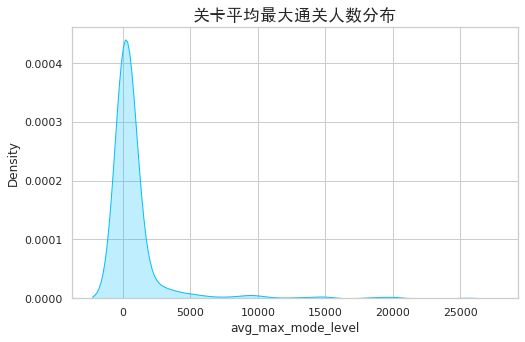

In [ ]:
plt.figure(dpi=100)
plt.figure(figsize=(8,5))

x = df.mode_level
y = df.avg_max_mode_level

sns.kdeplot(y, color='deepskyblue', shade = True)

plt.title('关卡平均最大通关人数分布', fontproperties=zhfont, size=17)

In [ ]:
gt = pd.read_csv('/content/game_times',
header = 0, #None表示没有， 0表示第1行
encoding="utf-8",
# index_col="topic" #没有index列
delimiter="	"
)

In [ ]:
gt

,game_times,count_game_times
0,1,143
1,2,15478
2,3,17586
3,4,20258
4,5,22334
...,...,...
323,383,1
324,390,1
325,413,1
326,414,1


Text(0.5, 1.0, '每人平均游戏次数分布')

<Figure size 2000x1600 with 0 Axes>

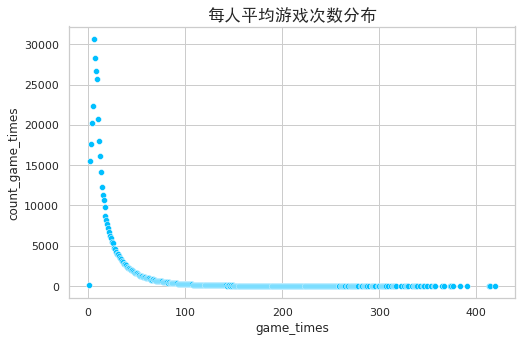

In [ ]:
plt.figure(dpi=100)
plt.figure(figsize=(8,5))

x = gt.game_times
y = gt.count_game_times

sns.scatterplot(data=gt,x = gt.game_times,y = gt.count_game_times,alpha=1, color='deepskyblue')

plt.title('每人平均游戏次数分布', fontproperties=zhfont, size=17)

In [ ]:
lt = pd.read_csv('/content/login_times',
header = 0, #None表示没有， 0表示第1行
encoding="utf-8",
# index_col="topic" #没有index列
delimiter="	"
)

In [ ]:
lt

Text(0.5, 1.0, '每人平均登录次数分布')

<Figure size 2000x1600 with 0 Axes>

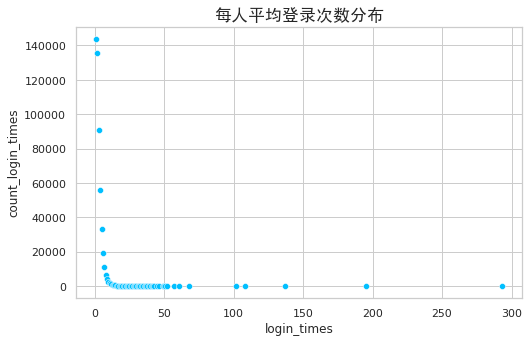

In [ ]:
plt.figure(dpi=100)
plt.figure(figsize=(8,5))

x = lt.login_times
y = lt.count_login_times

sns.scatterplot(data=lt,x = x,y = y,alpha=1, color='deepskyblue')

plt.title('每人平均登录次数分布', fontproperties=zhfont, size=17)

In [ ]:
us = pd.read_csv('/content/user',
header = 0, #None表示没有， 0表示第1行
encoding="utf-8",
# index_col="topic" #没有index列
delimiter="	"
)

In [ ]:
us

Text(0.5, 1.0, '新增用户每天登录人数')

<Figure size 2000x1600 with 0 Axes>

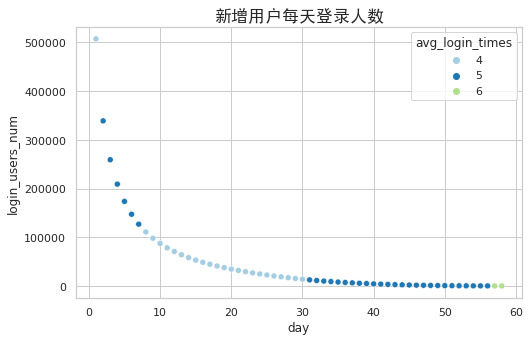

In [ ]:
plt.figure(dpi=100)
plt.figure(figsize=(8,5))

x = us.day
y = us.login_users_num

sns.scatterplot(data=us,x = x,y = y,alpha=1, hue='avg_login_times',palette='Paired')

plt.title('新增用户每天登录人数', fontproperties=zhfont, size=17)

Text(0.5, 1.0, '新增用户每天登录游戏时间')

<Figure size 2000x1600 with 0 Axes>

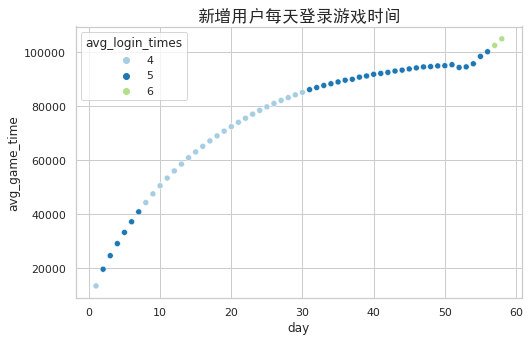

In [ ]:
plt.figure(dpi=100)
plt.figure(figsize=(8,5))

x = us.day
y = us.avg_game_time

sns.scatterplot(data=us,x = x,y = y,alpha=1, hue='avg_login_times',palette='Paired')
# plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))

plt.title('新增用户每天登录游戏时间', fontproperties=zhfont, size=17)